# Testing OC Loss

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.data import Batch

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from lightning_modules.toyGNN.submodels.naive_transformer import NaiveTransformer

/global/homes/d/danieltm/.conda/envs/gnn4itk-test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load config
with open("../configs/naive_transformer_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
model = NaiveTransformer(config)

## Test Dataloading

In [4]:
model.setup(stage="fit");

Setting up the data...
Error in event:  12  max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.
Error in event:  35  max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.
Error in event:  46  index 1 is out of bounds for dimension 1 with size 1
Error in event:  84  index 1 is out of bounds for dimension 1 with size 1
Error in event:  120  index 1 is out of bounds for dimension 1 with size 1
Error in event:  226  max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.
Error in event:  241  max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.
Error in event:  327  index 1 is out of bounds for dimension 1 with size 1
Error in event:  344  index 1 is out of bounds for dimension 1 with size 1
Error in event:  354  max(): Expec

In [5]:
sample = model.valset[0]

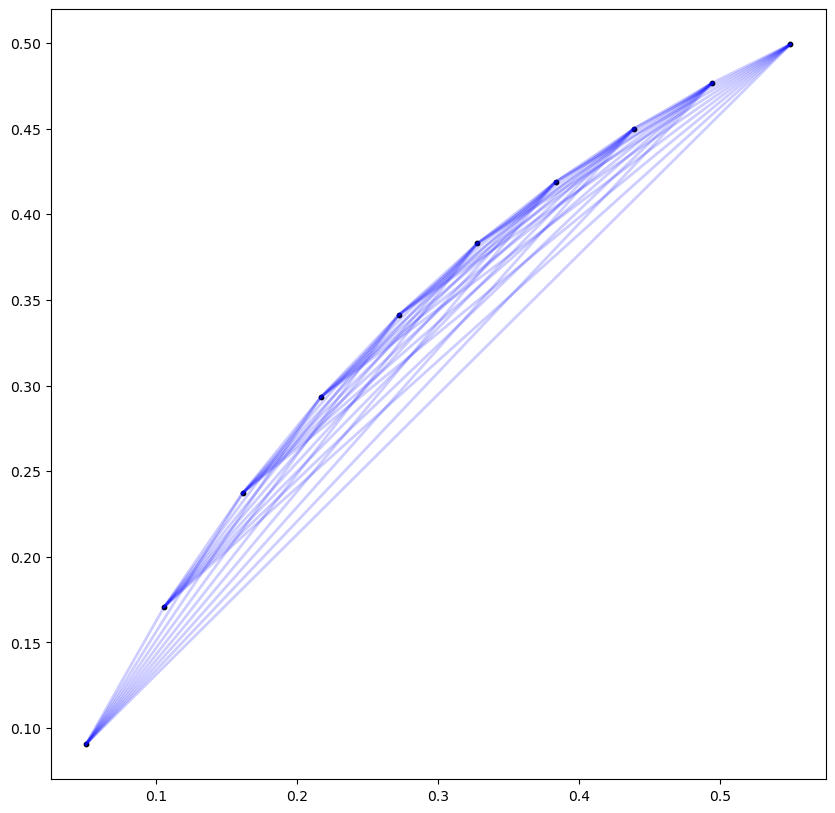

In [6]:
# Plot the graph
def plot_graph(sample):
    _, ax = plt.subplots(figsize=(10,10))
    ax.plot(sample.x[sample.edge_index,0], sample.x[sample.edge_index,1], c='b', alpha=0.1, linewidth=2)
    ax.scatter(sample.x[:,0], sample.x[:,1], s=10, c="k")
    plt.show()

plot_graph(sample)

## Train Model

In [ ]:
logger = WandbLogger(
    project="NaiveTransformer", group="InitialTest", save_dir=config["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=config["max_epochs"], logger=logger, num_sanity_val_steps=0
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                | Type                    | Params
----------------------------------------------------------------
0 | input_network       | Sequential              | 384   
1 | transformer_layer   | TransformerEncoderLayer | 99.6 K
2 | transformer_encoder | TransformerEncoder      | 398 K 
3 | user_network        | Sequential              | 67.6 K
----------------------------------------------------------------
565 K     Tr

Setting up the data...
Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=0.854, v_num=38ar]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]Tracking eff: 0.22174969623329283, tracking pur: 0.3806047966631908, tracking dup: 0.0, 
 num_valid_matched_particles: 365, num_valid_particles: 1646, num_valid_matched_clusters: 365, num_valid_clusters: 959, num_duplicated_clusters: 0
Rep eff: 0.5094992518424988, rep pur: 0.543529748916626, rep dup: 0.0
Clu eff: 1.0003652572631836, clu pur: 0.550260603427887
(1, 2)

Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 21.20it/s, loss=0.851, v_num=38ar]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]Tracking eff: 0.23754556500607532, tracking pur: 0.40771637122002086, tracking dup: 0.0, 
 num_valid_matched_particles: 391, num_valid_particles: 1646, num_valid_matched_clusters: 391, num_valid_clusters: 959, num_duplicated_clusters: 0
Rep eff: 0.520075738430023

In [8]:
from torch_geometric.nn import radius

In [12]:
test_database = torch.tensor([[0.0], [1.0], [2.0], [3.0], [4.0], [5.0]])
test_query = torch.tensor([[1.5]])
edges = radius(test_database, test_query, r=1.0)

In [13]:
edges

tensor([[0, 0],
        [1, 2]])

## Sanity Check Performance

In [8]:
model = model.to(device)
model.eval()
with torch.no_grad():
    for batch in model.val_dataloader():
        data = batch.to(device)
        output = model.shared_evaluation(data, 0)
        break

Rep eff: 0.829031229019165, rep pur: 0.9398969411849976, rep dup: 0.03626062348484993
Clu eff: 0.970241904258728, clu pur: 0.945155143737793
(1, 2)
(1, 2)


In [9]:
uu_edges = output["user_user_edges"]
uu_truth = output["user_user_truth"]
u_embed = output["user_embed"]

In [10]:
for pred_edge in uu_edges.T:
    if not (pred_edge == batch.edge_index.T).all(1).any():
        break

In [11]:
for true_edge in batch.edge_index.T:
    if not (true_edge == uu_edges.T).all(1).any():
        break

In [12]:
pred_edge

tensor([45, 61], device='cuda:0')

In [13]:
true_edge

tensor([45, 50], device='cuda:0')

In [14]:
node = 45
batch.edge_index[:, (batch.edge_index == node).any(0)]

tensor([[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54],
        [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 45, 45, 45, 45, 45, 45, 45, 45,
         45]], device='cuda:0')

In [15]:
uu_edges[:, (uu_edges == node).any(0)]

tensor([[45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 47, 48, 49, 61, 62, 63, 64],
        [45, 46, 47, 48, 49, 61, 62, 63, 64, 45, 45, 45, 45, 45, 45, 45, 45]],
       device='cuda:0')

In [21]:
batch_index = batch.batch[node]
batch.x[node], batch.pid[node], batch.batch[node]

(tensor([ 0.0500, -0.0170], device='cuda:0'),
 tensor(3847496192, device='cuda:0'),
 tensor(3, device='cuda:0'))

In [17]:
event_mask = batch.batch == batch.batch[node]
uu_edges_event = uu_edges[:, event_mask[uu_edges].all(0)]
uu_true_edges_event = uu_edges[:, uu_truth][:, event_mask[uu_edges[:, uu_truth]].all(0)]
uu_fake_edges_event = uu_edges[:, ~uu_truth][:, event_mask[uu_edges[:, ~uu_truth]].all(0)]
uu_truth_event = batch.edge_index[:, event_mask[batch.edge_index].all(0)]

In [25]:
# Get distance between u_embed of edges in uu_edges
torch.sum((u_embed[uu_edges_event[0]] - u_embed[uu_edges_event[1]])**2, dim=1)

tensor([0.0000, 0.9090, 0.9050, 0.9083, 0.8981, 0.9129, 0.9545, 0.9090, 0.0000,
        0.0939, 0.1654, 0.2341, 0.3336, 0.4117, 0.5168, 0.9655, 0.9050, 0.0939,
        0.0000, 0.0145, 0.0706, 0.1385, 0.1856, 0.2632, 0.6852, 0.9083, 0.1654,
        0.0145, 0.0000, 0.0325, 0.0843, 0.1330, 0.2211, 0.6584, 0.8981, 0.2341,
        0.0706, 0.0325, 0.0000, 0.0183, 0.0801, 0.2343, 0.7734, 0.9129, 0.3336,
        0.1385, 0.0843, 0.0183, 0.0000, 0.0355, 0.1907, 0.7354, 0.9545, 0.4117,
        0.1856, 0.1330, 0.0801, 0.0355, 0.0000, 0.0799, 0.5200, 0.5168, 0.2632,
        0.2211, 0.2343, 0.1907, 0.0799, 0.0000, 0.2015, 0.8091, 0.9655, 0.6852,
        0.6584, 0.7734, 0.7354, 0.5200, 0.2015, 0.0000, 0.2127, 0.8091, 0.2127,
        0.0000, 0.0000, 0.1857, 0.2875, 0.2412, 0.2183, 0.2517, 0.2812, 0.2881,
        0.3056, 0.3533, 0.1857, 0.0000, 0.0492, 0.0903, 0.1565, 0.2339, 0.2364,
        0.2425, 0.2448, 0.2777, 0.2875, 0.0492, 0.0000, 0.0266, 0.0879, 0.1428,
        0.1336, 0.1397, 0.1455, 0.1835, 

In [26]:
torch.sum((u_embed[uu_truth_event[0]] - u_embed[uu_truth_event[1]])**2, dim=1)

tensor([0.0000e+00, 9.0896e-01, 9.0502e-01, 9.0828e-01, 8.9814e-01, 9.1286e-01,
        9.5448e-01, 1.0506e+00, 1.4175e+00, 2.2410e+00, 9.0896e-01, 0.0000e+00,
        9.3882e-02, 1.6536e-01, 2.3414e-01, 3.3357e-01, 4.1174e-01, 5.1678e-01,
        9.6549e-01, 1.7722e+00, 9.0502e-01, 9.3882e-02, 0.0000e+00, 1.4529e-02,
        7.0637e-02, 1.3845e-01, 1.8562e-01, 2.6322e-01, 6.8524e-01, 1.4746e+00,
        9.0828e-01, 1.6536e-01, 1.4529e-02, 0.0000e+00, 3.2530e-02, 8.4259e-02,
        1.3304e-01, 2.2106e-01, 6.5843e-01, 1.4801e+00, 8.9814e-01, 2.3414e-01,
        7.0637e-02, 3.2530e-02, 0.0000e+00, 1.8265e-02, 8.0124e-02, 2.3428e-01,
        7.7344e-01, 1.7096e+00, 9.1286e-01, 3.3357e-01, 1.3845e-01, 8.4259e-02,
        1.8265e-02, 0.0000e+00, 3.5510e-02, 1.9071e-01, 7.3540e-01, 1.6833e+00,
        9.5448e-01, 4.1174e-01, 1.8562e-01, 1.3304e-01, 8.0124e-02, 3.5510e-02,
        0.0000e+00, 7.9903e-02, 5.2000e-01, 1.3597e+00, 1.0506e+00, 5.1678e-01,
        2.6322e-01, 2.2106e-01, 2.3428e-

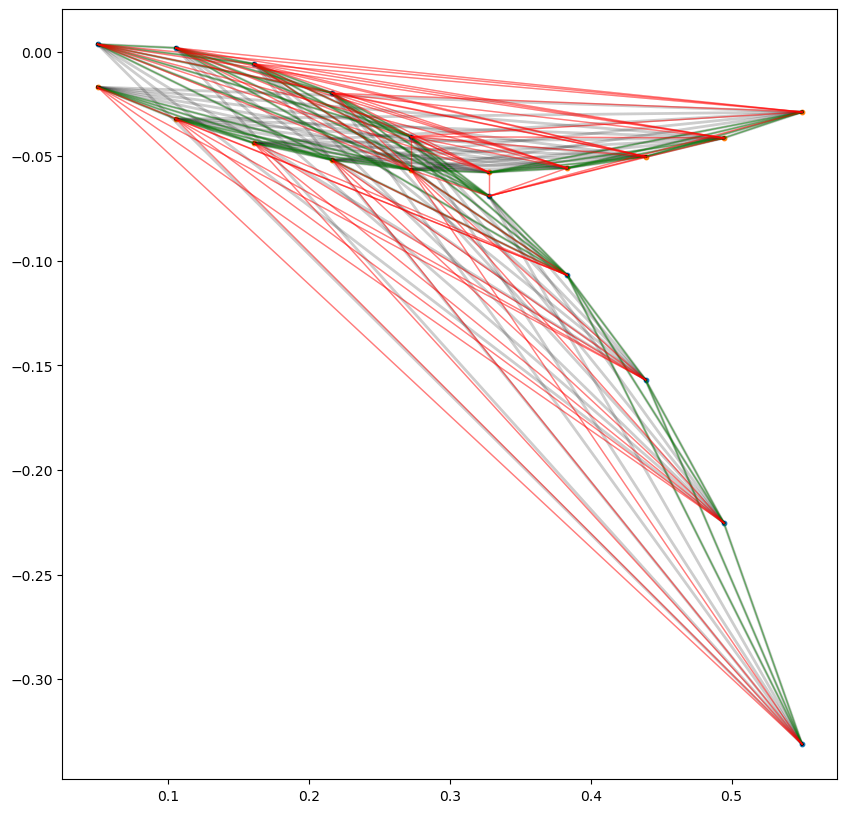

In [18]:
# Plot uu_edges
_, ax = plt.subplots(figsize=(10,10))

# Plot uu_truth
ax.plot(batch.x[uu_truth_event,0].cpu(), batch.x[uu_truth_event,1].cpu(), c='k', alpha=0.1, linewidth=2)

# Plot uu_true_edges
ax.plot(batch.x[uu_true_edges_event,0].cpu(), batch.x[uu_true_edges_event,1].cpu(), c='g', alpha=0.3, linewidth=1)

# Plot uu_fake_edges
ax.plot(batch.x[uu_fake_edges_event,0].cpu(), batch.x[uu_fake_edges_event,1].cpu(), c='r', alpha=0.3, linewidth=1)

# Plot each x with a PID color
for pid in torch.unique(batch.pid[event_mask]):
    x = batch.x[event_mask][batch.pid[event_mask] == pid]
    ax.scatter(x[:,0].cpu(), x[:,1].cpu(), s=10, label=pid)

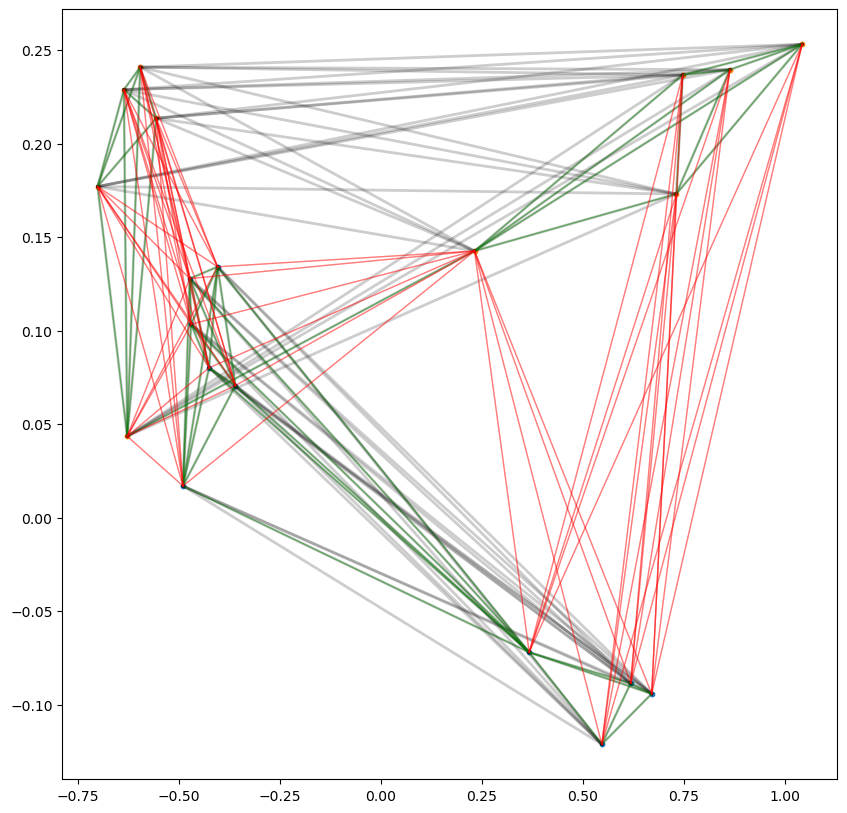

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(u_embed.cpu().numpy())

u_embed_pca = pca.transform(u_embed.cpu().numpy())

# Plot uu_edges
_, ax = plt.subplots(figsize=(10,10))

# Plot uu_truth
ax.plot(u_embed_pca[uu_truth_event.cpu(),0], u_embed_pca[uu_truth_event.cpu(),1], c='k', alpha=0.1, linewidth=2)

# Plot uu_true_edges
ax.plot(u_embed_pca[uu_true_edges_event.cpu(),0], u_embed_pca[uu_true_edges_event.cpu(),1], c='g', alpha=0.3, linewidth=1)

# Plot uu_fake_edges
ax.plot(u_embed_pca[uu_fake_edges_event.cpu(),0], u_embed_pca[uu_fake_edges_event.cpu(),1], c='r', alpha=0.3, linewidth=1)

# Plot each x with a PID color
for pid in torch.unique(batch.pid[event_mask]):
    x = u_embed_pca[event_mask.cpu()][batch.pid[event_mask].cpu() == pid.cpu()]
    ax.scatter(x[:,0], x[:,1], s=10, label=pid)

## Visualize Output

In [22]:
model = model.to(device)
model.eval()
with torch.no_grad():
    data = model.valset[batch_index]
    input_data = model.get_input_data(data.to(device))
    user_embed = model(input_data)
    user_influencer_edges, user_influencer_truth = model.get_condensation_edges(data, user_embed)
    fig = model.plot_embedding_native(data, user_embed, spatial2=user_embed, ui_edges=user_influencer_edges)
    fig.show()

user_embed, user_influencer_edges, user_influencer_truth = user_embed.cpu(), user_influencer_edges.cpu(), user_influencer_truth.cpu()

In [23]:
model.plot_embedding_native(data, data.x, spatial2=data.x, ui_edges=user_influencer_edges)

ValueError: X has 2 features, but IncrementalPCA is expecting 12 features as input.

In [25]:
eff, pur, dup = model.get_representative_metrics(data, user_influencer_edges, user_influencer_truth)
print(f"Efficiency: {eff:.3f}, Purity: {pur:.3f}, Duplication: {dup:.3f}")

Efficiency: 0.400, Purity: 1.000, Duplication: 0.000


In [26]:
model.get_representative_metrics(data, data.edge_index, torch.ones(data.edge_index.shape[1], dtype=torch.bool))

(tensor(1., device='cuda:0'), tensor(1.), tensor(9.))

In [32]:
# Get 1D PCA of user_embed, influencer_embed
from sklearn.decomposition import PCA
import plotly.graph_objects as go
pca = PCA(n_components=1)
all_embed = torch.cat([user_embed, influencer_embed], dim=0)
pca.fit(all_embed.cpu().numpy())
all_pca = pca.transform(all_embed.cpu().numpy())
user_pca = pca.transform(user_embed.cpu().numpy())
influencer_pca = pca.transform(influencer_embed.cpu().numpy())

NameError: name 'influencer_embed' is not defined

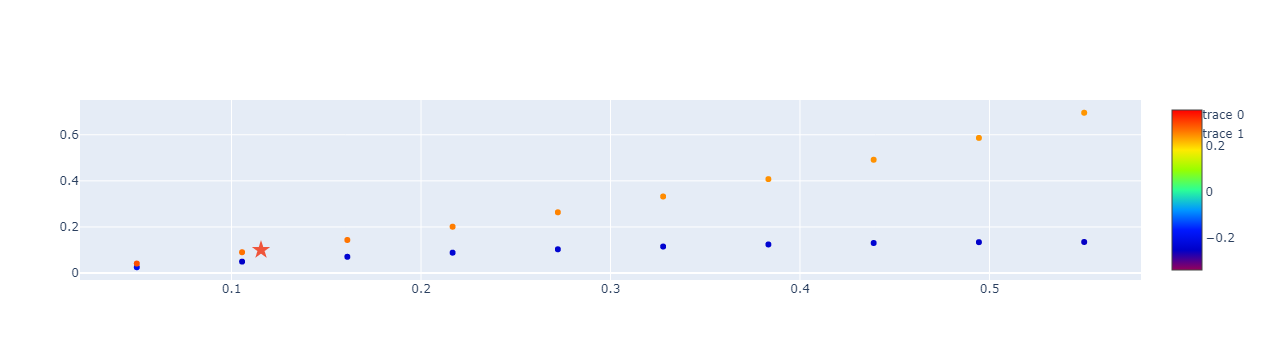

In [58]:
fig = go.Figure()
# plot the user embedding, with color given by the position in 1D PCA
# Make a color scale from all_pca
fig.add_trace(go.Scatter(x=data.x[:,0].cpu(), y=data.x[:,1].cpu(), mode='markers', marker=dict(cmin = all_pca.min(), cmax = all_pca.max(), color=user_pca[:,0], colorscale='Rainbow', showscale=True)))

# plot the representatives, with color given by the position in 1D PCA
representatives = user_influencer_edges[1].unique().cpu()
# fig.add_trace(go.Scatter(x=(batch.x[:,0].cpu() + 0.01), y=(batch.x[:,1].cpu() + 0.01), mode='markers', marker=dict(cmin = all_pca.min(), cmax = all_pca.max(), color=influencer_pca[:,0], colorscale='Viridis', showscale=True, symbol="star")))
fig.add_trace(go.Scatter(x=data.x[representatives,0].cpu() + 0.01, y=data.x[representatives,1].cpu() + 0.01, mode='markers', marker=dict(cmin = all_pca.min(), cmax = all_pca.max(), color=influencer_pca[representatives,0], colorscale='Rainbow', symbol="star", size=14)))

In [59]:
influencer_pca[representatives,0]

0.2876145

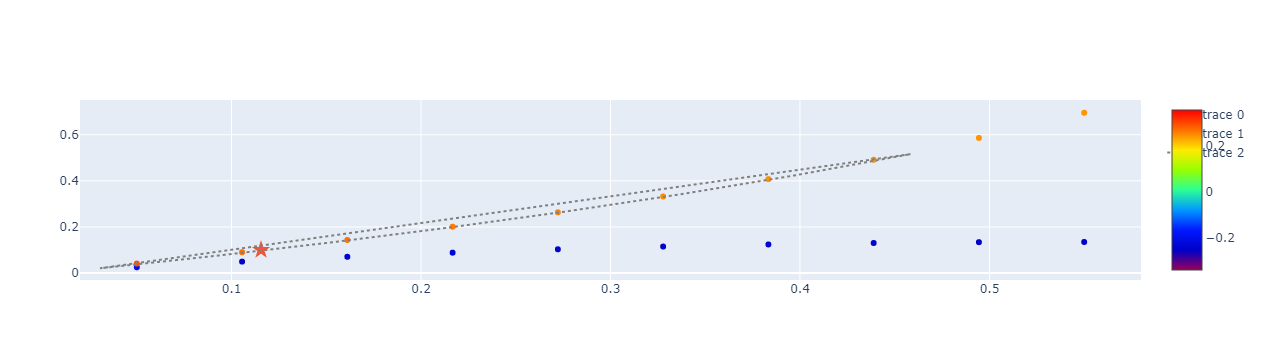

In [67]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

def convex_hull_plotly(points):
    # Compute the convex hull
    hull = ConvexHull(points)

    # Scale the hull to add some margin
    margin_factor = 1.1  # adjust as desired
    center = np.mean(points[hull.vertices, :], axis=0)
    center_repeated = np.repeat(center[np.newaxis, :], hull.vertices.shape[0], axis=0)
    scaled_hull_vertices = margin_factor * (points[hull.vertices, :] - center_repeated) + center_repeated

    # Close the polygon
    scaled_hull_vertices = np.vstack([scaled_hull_vertices, scaled_hull_vertices[0]])

    return scaled_hull_vertices

fig = go.Figure()

# plot the user embedding, with color given by the position in 1D PCA
# Make a color scale from all_pca
fig.add_trace(go.Scatter(x=data.x[:,0].cpu(), y=data.x[:,1].cpu(), mode='markers', marker=dict(cmin = all_pca.min(), cmax = all_pca.max(), color=user_pca[:,0], colorscale='Rainbow', showscale=True)))

# plot the representatives, with color given by the position in 1D PCA
representatives = user_influencer_edges[1].unique().cpu()

# plot the representatives as stars
fig.add_trace(go.Scatter(x=data.x[representatives,0].cpu() + 0.01, y=data.x[representatives,1].cpu() + 0.01, mode='markers', marker=dict(cmin = all_pca.min(), cmax = all_pca.max(), color=influencer_pca[representatives,0], colorscale='Rainbow', symbol="star", size=14)))

for rep in representatives:
    # get indices of users belonging to current representative
    indices = user_influencer_edges[0, user_influencer_edges[1].cpu() == rep].unique()
    # get x and y coordinates of these users
    x = data.x[indices, 0].cpu().numpy()
    y = data.x[indices, 1].cpu().numpy()

    # get convex hull of these users
    hull = convex_hull_plotly(np.vstack([x, y]).T)

    # plot the convex hull
    fig.add_trace(go.Scatter(x=hull[:,0], y=hull[:,1], mode='lines', line=dict(dash='dot', color='grey')))

fig.show()